In [3]:
pip install seaborn --proxy proxy.toshiba.co.jp:8080

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pickle
import re
import os
import glob

import sys
sys.path.append('../')
from scib import Plotter

plt.rcParams["font.size"] = 18

In [5]:
log_categories = {
    'adv': {
        'columns': ['time', 'addr'],
        'dtypes': [int, str],
        'pattern': r'00> (\d{10}),a,([0-9a-zA-Z]{2}:[0-9a-zA-Z]{2}:[0-9a-zA-Z]{2}:[0-9a-zA-Z]{2}:[0-9a-zA-Z]{2}:[0-9a-zA-Z]{2})*'
    },
    'connected': {
        'columns': ['time', 'conn_handle', 'addr'],
        'dtypes': [int, int, str],
        'pattern': r'00> (\d{10}),c,(\d+),([0-9a-zA-Z]{2}:[0-9a-zA-Z]{2}:[0-9a-zA-Z]{2}:[0-9a-zA-Z]{2}:[0-9a-zA-Z]{2}:[0-9a-zA-Z]{2})*'
    },
    'disconnected': {
        'columns': ['time', 'cmu_index', 'addr'],
        'dtypes': [int, int, str],
        'pattern': r'00> (\d{10}),d,(\d+),([0-9a-zA-Z]{2}:[0-9a-zA-Z]{2}:[0-9a-zA-Z]{2}:[0-9a-zA-Z]{2}:[0-9a-zA-Z]{2}:[0-9a-zA-Z]{2})*'
    },
    'vs': {
        'columns': ['time', 'conn_handle', 'cc'],
        'dtypes': [int, int, int],
        'pattern': r'00> (\d{10}),v,(\d+),(\d+$)'
    },
    'qos': {
        'columns': ['time', 'conn_handle', 'channel_index', 'event_counter', 'crc_ok_count', 'crc_error_count', 'nak_count', 'rx_timeout', 'rssi'],
        'dtypes': [int, int, int, int, int, int, int, int, int],
        'pattern': r'00> (\d{10}),q,(\d+),(\d+),(\d{6}),*,(\d+),(\d+),(\d+),(\d+),(-\d+$)'
    }
}

In [6]:
log_dir = 'log'
log_files = {
    'g1': '20230411-0849-bmu.log',
    # 'g2': '20230214_183443_COM42.log',
    # 'g3': '20230214_183508_COM56.log',
    # 'g4': '20230214_183512_COM57.log'
}
dfs = {}
for group in log_files.keys():
    dfs[group] = {}

In [7]:
dfs_filename = os.path.join(log_dir, 'dfs.pickle')

if os.path.isfile(dfs_filename):
    with open(dfs_filename, 'rb') as f:
        dfs = pickle.load(f)
        print('dfs has been loaded.')
else:
    for group, filename in log_files.items():
        print(group)
        with open(os.path.join(log_dir, filename)) as f:
            lines = f.readlines()
            for df_name, info in log_categories.items():
                repatter = re.compile(info['pattern'])
                match_lines = [repatter.match(l).groups() for l in lines if repatter.match(l)]
                dfs[group][df_name] = pd.DataFrame(match_lines, columns=info['columns'], dtype=str)
                for column, dtype in zip(info['columns'], info['dtypes']):
                    dfs[group][df_name][column] = dfs[group][df_name][column].astype(dtype)
                dfs[group][df_name]['timedelta'] = dfs[group][df_name]['time'].apply(lambda x: datetime.timedelta(milliseconds=x))
                dfs[group][df_name].set_index('timedelta')
    with open(dfs_filename, 'wb') as f:
        pickle.dump(dfs, f)
        print('dfs has been dumped.')

dfs has been loaded.


In [8]:
# Check the duration in hours
for group in dfs.keys():
    print(group, datetime.timedelta(milliseconds=dfs[group]['vs']['time'].max().item()))

g1 0:31:37.618000


In [9]:
n_cmu = 0
for group in dfs.keys():
    n_cmu = max(n_cmu, len(dfs[group]['connected']['conn_handle'].unique()))
n_cmu

1

In [10]:
dfs['g1']['vs']

,time,conn_handle,cc,timedelta
0,138958,0,3,0 days 00:02:18.958000
1,138959,0,4,0 days 00:02:18.959000
2,139078,0,5,0 days 00:02:19.078000
3,139198,0,6,0 days 00:02:19.198000
4,139318,0,7,0 days 00:02:19.318000
...,...,...,...,...
14649,1897138,0,60,0 days 00:31:37.138000
14650,1897258,0,61,0 days 00:31:37.258000
14651,1897378,0,62,0 days 00:31:37.378000
14652,1897498,0,63,0 days 00:31:37.498000


In [11]:
dfs['g1']['qos']


,time,conn_handle,channel_index,event_counter,crc_ok_count,crc_error_count,nak_count,rx_timeout,rssi,timedelta
0,138478,0,7,0,1,0,0,0,-23,0 days 00:02:18.478000
1,138538,0,3,1,1,0,0,0,-21,0 days 00:02:18.538000
2,138598,0,26,2,1,0,0,0,-26,0 days 00:02:18.598000
3,138658,0,27,3,1,0,0,0,-25,0 days 00:02:18.658000
4,138718,0,21,4,1,0,0,0,-26,0 days 00:02:18.718000
...,...,...,...,...,...,...,...,...,...,...
29317,1897498,0,23,29317,1,0,0,0,-24,0 days 00:31:37.498000
29318,1897558,0,26,29318,1,0,0,0,-25,0 days 00:31:37.558000
29319,1897618,0,29,29319,1,0,0,0,-26,0 days 00:31:37.618000
29320,1897678,0,16,29320,1,0,0,0,-24,0 days 00:31:37.678000


In [12]:
group_handle2addr = {}
for group in dfs.keys():
    group_handle2addr[group] = {}
    for conn_handle in range(n_cmu):
        group_handle2addr[group][conn_handle] = dfs[group]['connected'].query('conn_handle==@conn_handle').iloc[-1]['addr']
group_handle2addr

{'g1': {0: 'F8:57:E6:87:B8:2C'}}

In [13]:
datetime.timedelta(minutes=30).total_seconds() * 1000

1800000.0

In [14]:
# Remove first 30 minutes and leave 8 hours data
for group, df_group in dfs.items():
    for category, df in df_group.items():
        time_start = datetime.timedelta(minutes=30).total_seconds() * 1000
        time_end = time_start + datetime.timedelta(hours=8).total_seconds() * 1000
        dfs[group][category] = df.query('@time_start < time < @time_end').reset_index(drop=True)

In [15]:
# Check the duration in hours
for group in dfs.keys():
    print(group, datetime.timedelta(milliseconds=dfs[group]['vs']['time'].max().item()))

g1 0:31:37.618000


In [16]:
# Check the number of conn handle
for group in dfs.keys():
    print(group, len(dfs[group]['vs']['conn_handle'].unique()))

g1 1


In [17]:
for group in dfs.keys():
    for conn_handle in range(n_cmu):
        dfs[group]['vs'].loc[dfs[group]['vs']['conn_handle']==conn_handle, 'delayed'] = dfs[group]['vs'].query('conn_handle==@conn_handle')['time'].diff()>150
        dfs[group]['vs'].loc[dfs[group]['vs']['conn_handle']==conn_handle, 'delayed'] = dfs[group]['vs'].loc[dfs[group]['vs']['conn_handle']==conn_handle, 'delayed'].astype(float)

In [18]:
# Check the number of disconnection
for group in dfs.keys():
    print(group, len(dfs[group]['disconnected']))

g1 0


## Analysis 



In [19]:
dfs['g1']['qos']['channel_index'].max()

36

In [20]:
dfs['g1']['qos'][['crc_ok_count', 'crc_error_count']].drop_duplicates()

,crc_ok_count,crc_error_count
0,1,0


In [21]:
dfs['g1']['qos']

,time,conn_handle,channel_index,event_counter,crc_ok_count,crc_error_count,nak_count,rx_timeout,rssi,timedelta
0,1800058,0,3,27693,1,0,0,0,-23,0 days 00:30:00.058000
1,1800118,0,1,27694,1,0,0,0,-24,0 days 00:30:00.118000
2,1800178,0,32,27695,1,0,0,0,-25,0 days 00:30:00.178000
3,1800238,0,15,27696,1,0,0,0,-24,0 days 00:30:00.238000
4,1800298,0,21,27697,1,0,0,0,-25,0 days 00:30:00.298000
...,...,...,...,...,...,...,...,...,...,...
1624,1897498,0,23,29317,1,0,0,0,-24,0 days 00:31:37.498000
1625,1897558,0,26,29318,1,0,0,0,-25,0 days 00:31:37.558000
1626,1897618,0,29,29319,1,0,0,0,-26,0 days 00:31:37.618000
1627,1897678,0,16,29320,1,0,0,0,-24,0 days 00:31:37.678000


In [36]:
dfs['g1']['qos']['crc_error_count'].sum()

0

In [22]:
dfs['g1']['qos'].query('channel_index==0')

,time,conn_handle,channel_index,event_counter,crc_ok_count,crc_error_count,nak_count,rx_timeout,rssi,timedelta
24,1801498,0,0,27717,1,0,0,0,-23,0 days 00:30:01.498000
70,1804258,0,0,27763,1,0,0,0,-22,0 days 00:30:04.258000
97,1805878,0,0,27790,1,0,0,0,-23,0 days 00:30:05.878000
169,1810198,0,0,27862,1,0,0,0,-23,0 days 00:30:10.198000
194,1811698,0,0,27887,1,0,0,0,-23,0 days 00:30:11.698000
220,1813258,0,0,27913,1,0,0,0,-23,0 days 00:30:13.258000
222,1813378,0,0,27915,1,0,0,0,-23,0 days 00:30:13.378000
303,1818238,0,0,27996,1,0,0,0,-22,0 days 00:30:18.238000
306,1818418,0,0,27999,1,0,0,0,-23,0 days 00:30:18.418000
369,1822198,0,0,28062,1,0,0,0,-23,0 days 00:30:22.198000


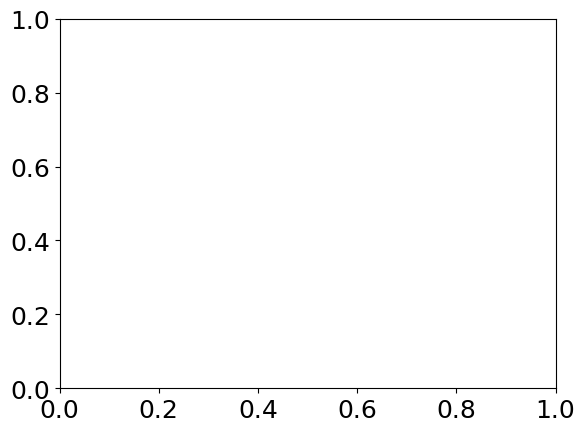

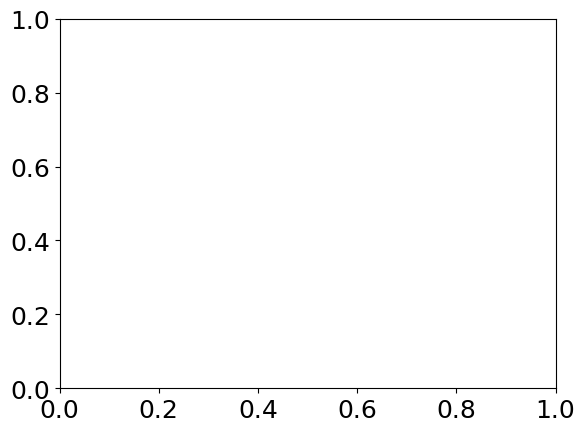

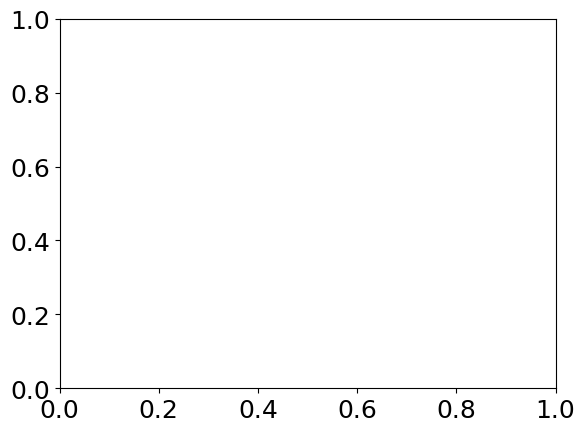

In [23]:
for i in range(3):
    fig = plt.figure()
    ax = fig.add_subplot()
    plt.show()

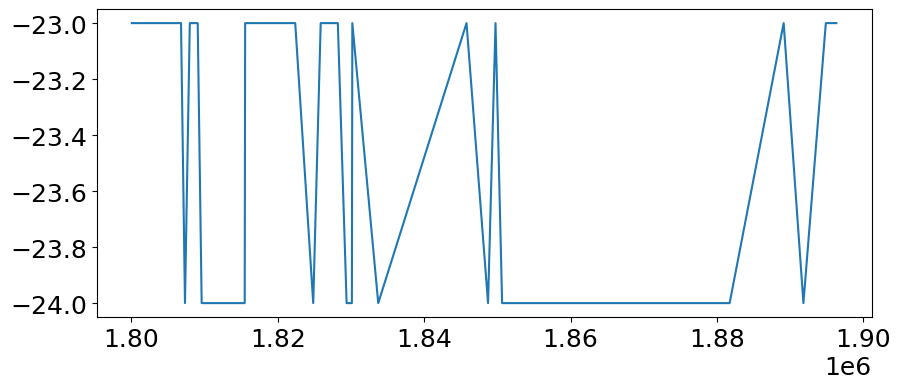

In [24]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot()
df=dfs['g1']['qos'].query('channel_index==3')
x=df['time']
y=df['rssi']
ax.plot(x, y)

In [25]:
for group in dfs.keys():
    dfs[group]['qos']['result'] = pd.Series(dtype=str)
    dfs[group]['qos'].loc[(dfs[group]['qos']['crc_ok_count']==0) & (dfs[group]['qos']['crc_error_count']==0), 'result'] = 'not arrived'
    dfs[group]['qos'].loc[(dfs[group]['qos']['crc_ok_count']>0), 'result'] = 'ok'
    dfs[group]['qos'].loc[(dfs[group]['qos']['crc_error_count']>0), 'result'] = 'error'

g1	0	max delay:180.0(ms)	delay prob:1.23153e-03
max delay(qos):60.0(ms)	

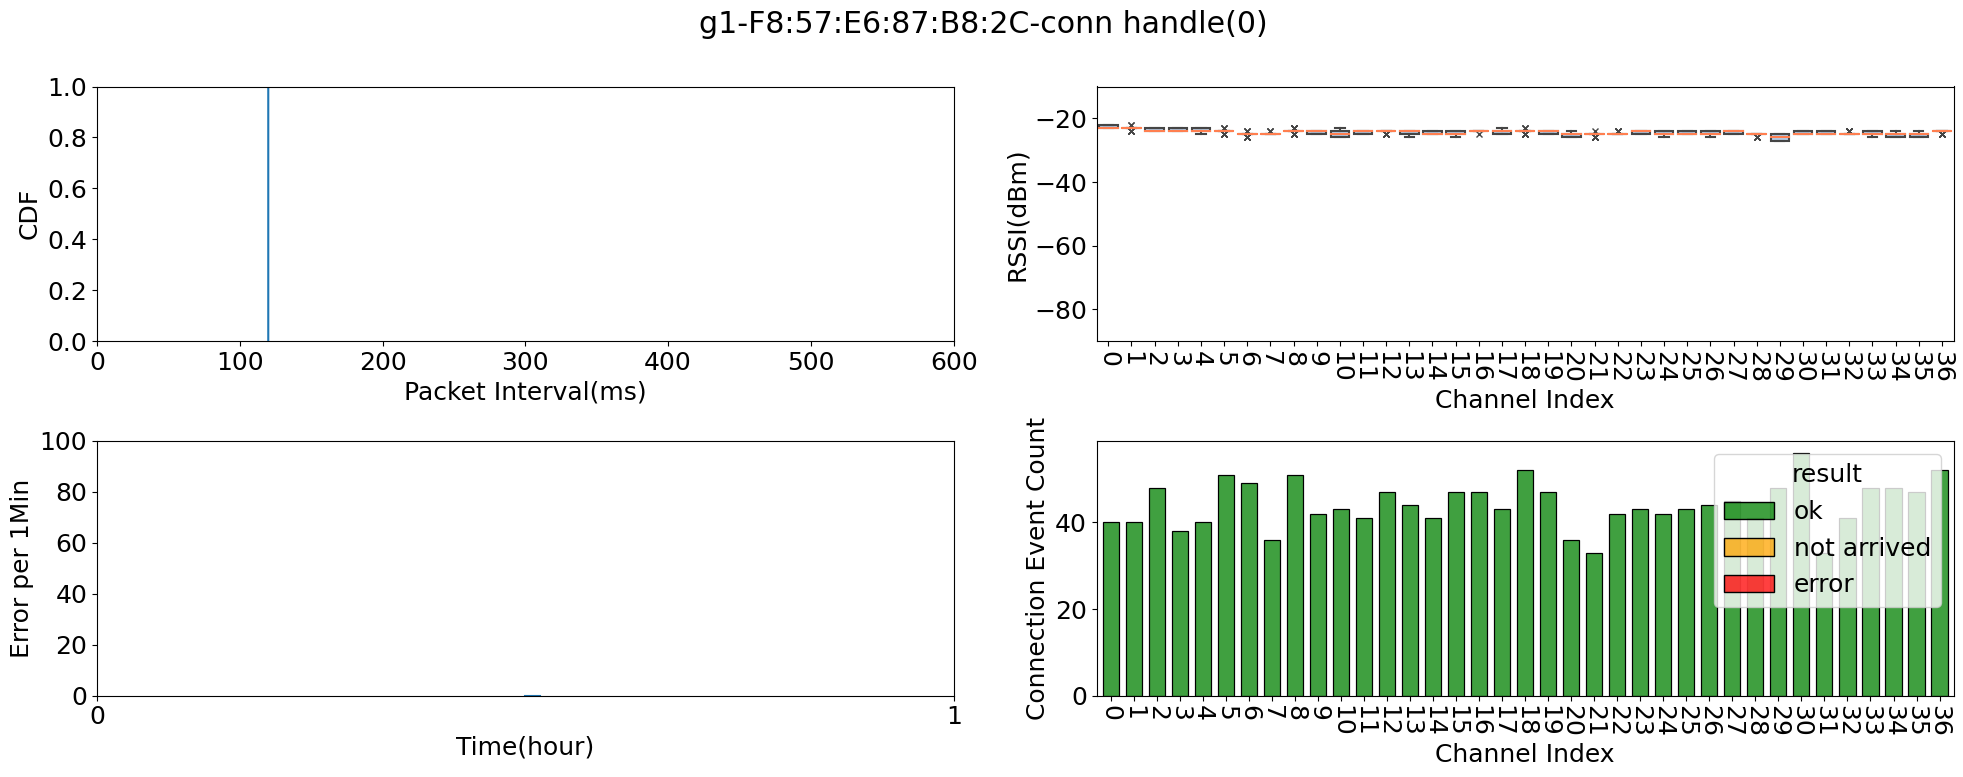

In [26]:
# delay check
for group, df_group in dfs.items():
    for conn_handle, addr in sorted(group_handle2addr[group].items(), key=lambda x: x[1]):
        print(group, end='\t')
        print(conn_handle, end='\t')
        df_diff = df_group['vs'].query('conn_handle==@conn_handle')['time'].diff().iloc[1:, ]
        print(f'max delay:{df_diff.max()}(ms)', end='\t')
        print(f'delay prob:{len(df_diff[df_diff>150])/len(df_diff):.5e}')
        df_diff_qos = df_group['qos'].query('conn_handle==@conn_handle')['time'].diff().iloc[1:, ]
        print(f'max delay(qos):{df_diff_qos.max()}(ms)', end='\t')

        fig = plt.figure(figsize=(20, 8))
        fig.suptitle(f'{group}-{addr}-conn handle({conn_handle})')
        ax1 = fig.add_subplot(2, 2, 1)
        Plotter.ecdf(df_group['vs'], conn_handle, ax1)

        ax2 = fig.add_subplot(2, 2, 2)
        Plotter.rssi_box(df_group['qos'], conn_handle, ax2)

        ax3 = fig.add_subplot(2,2,3)
        Plotter.delay_transition_qos(df_group['qos'], conn_handle, ax3, ylim=(0, 100))
        # Plotter.delay_transition(df_group['vs'], conn_handle, ax3)

        ax4 = fig.add_subplot(2, 2, 4)
        Plotter.crc_hist(df_group['qos'], conn_handle, ax4)

        plt.tight_layout()
        plt.show()

        list(df_group['qos'][df_group['qos']['conn_handle'] == conn_handle]['channel_index'].unique())
        print()

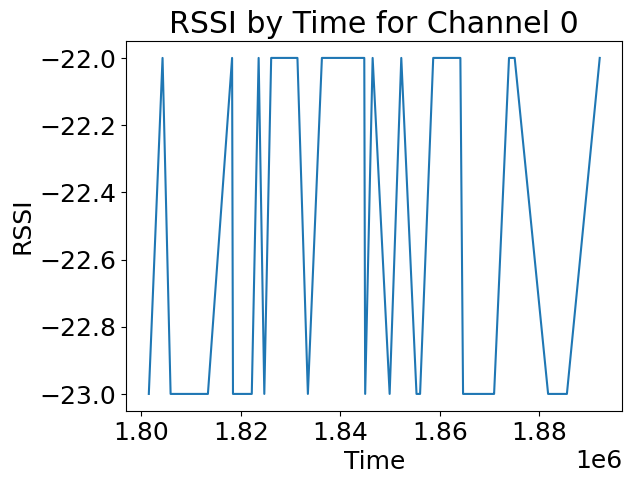

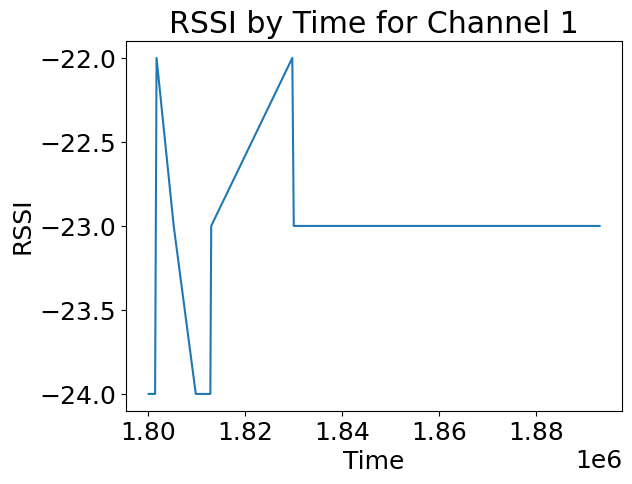

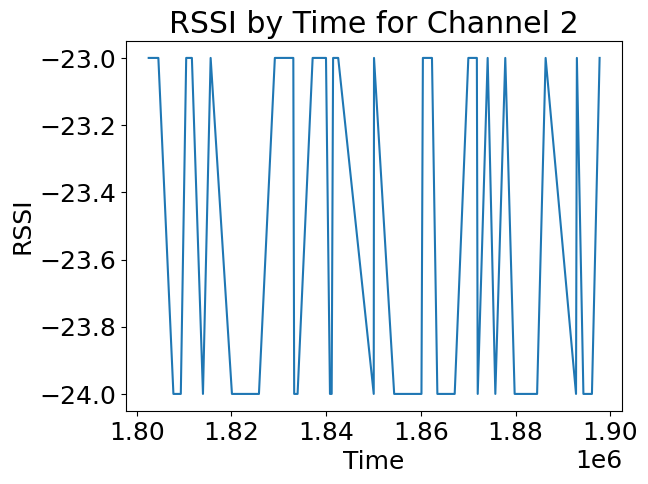

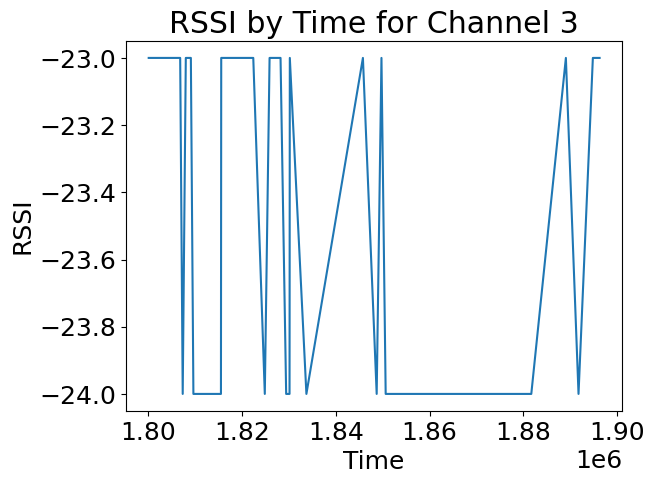

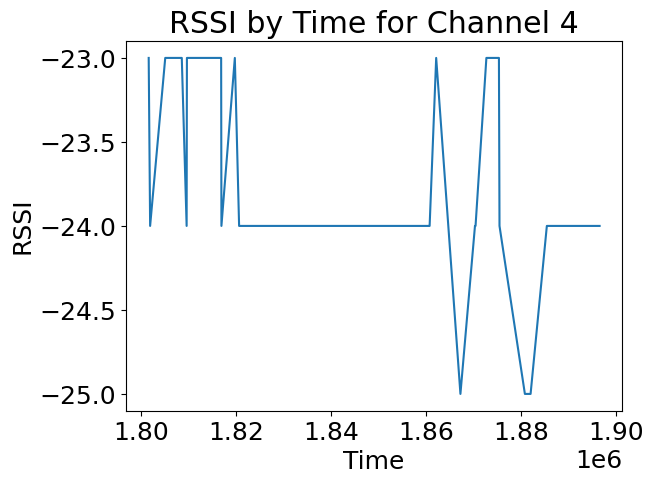

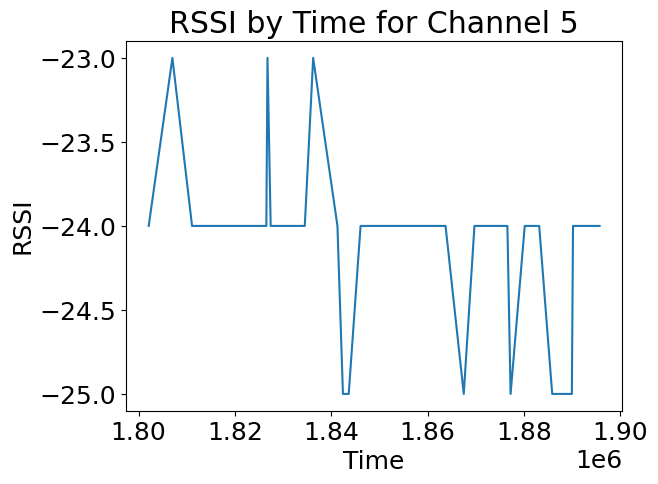

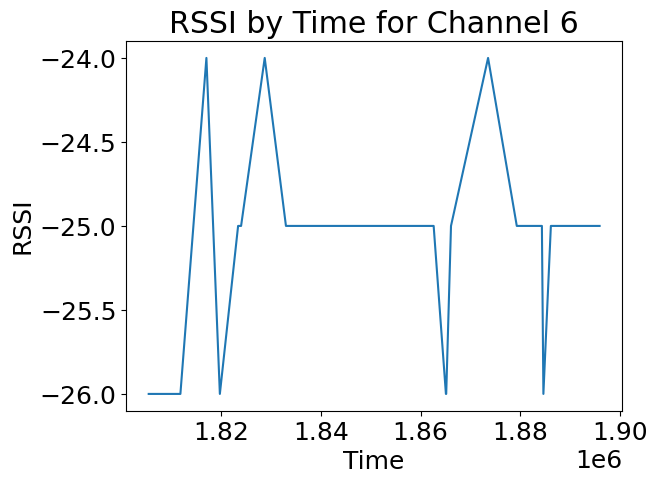

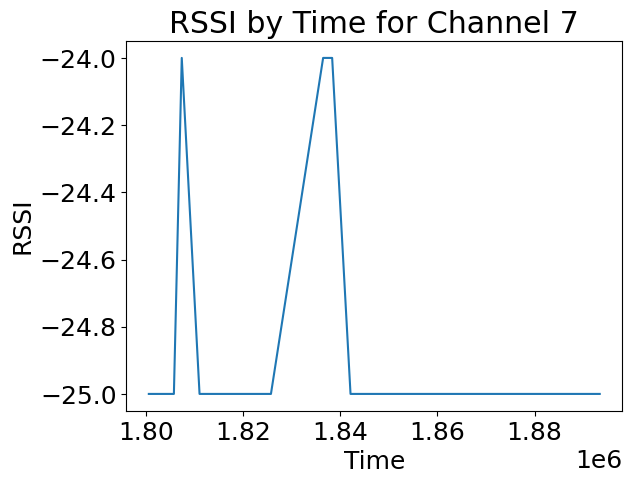

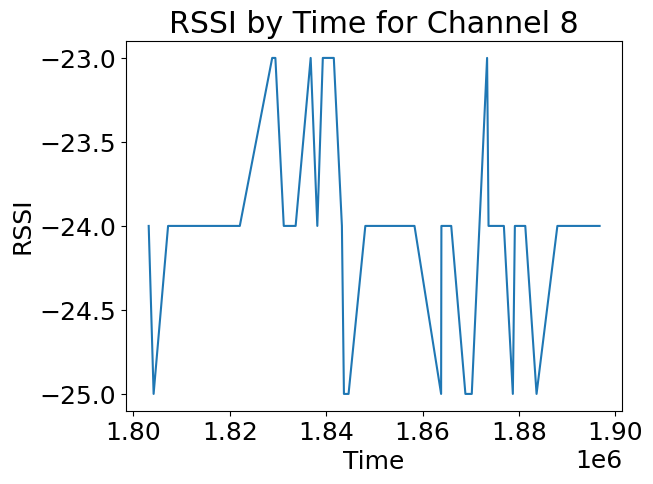

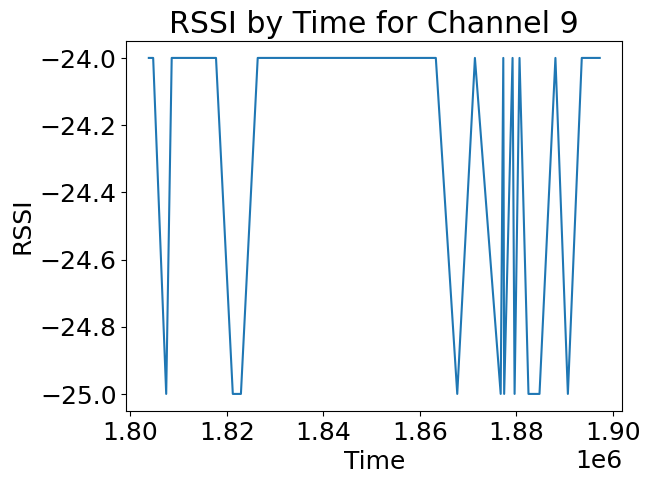

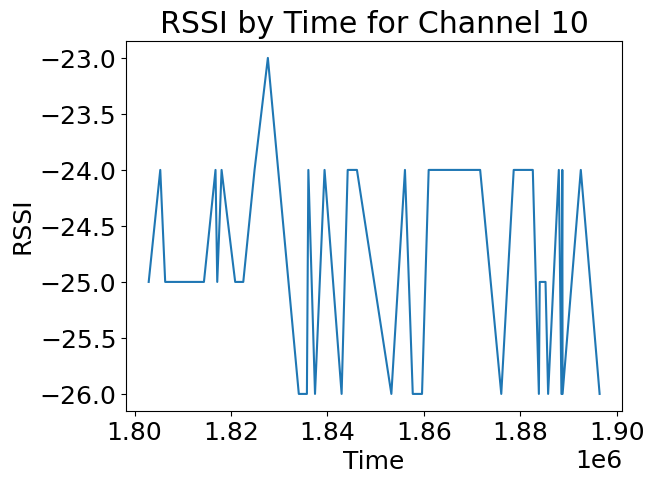

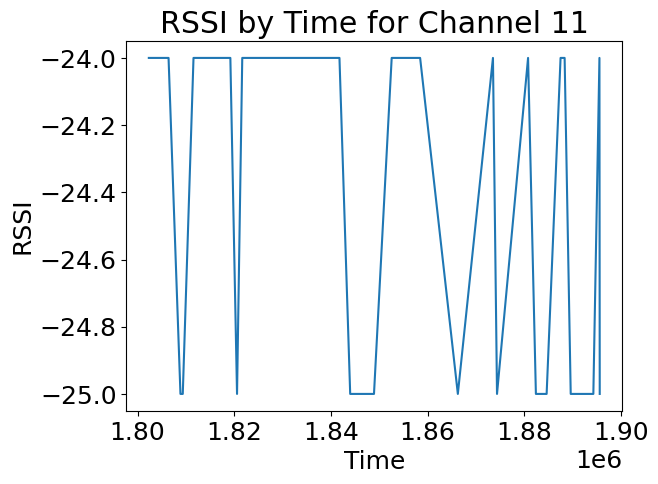

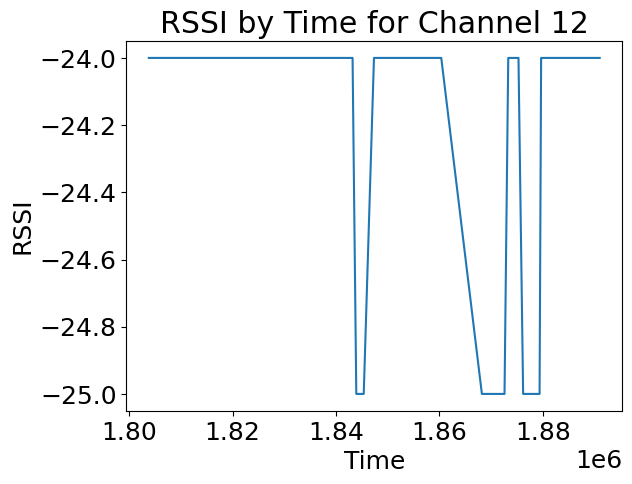

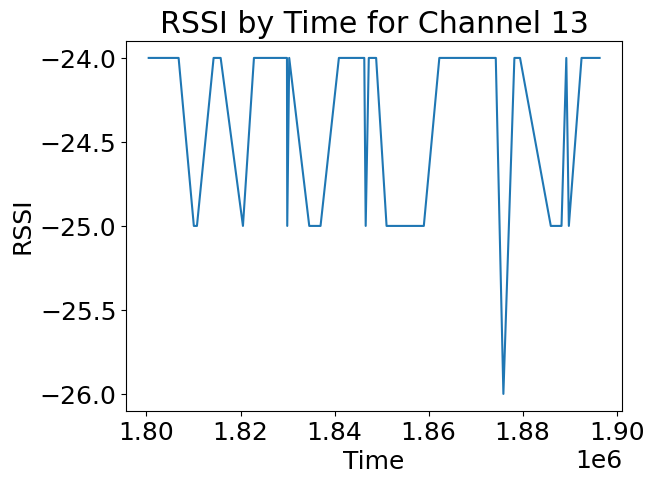

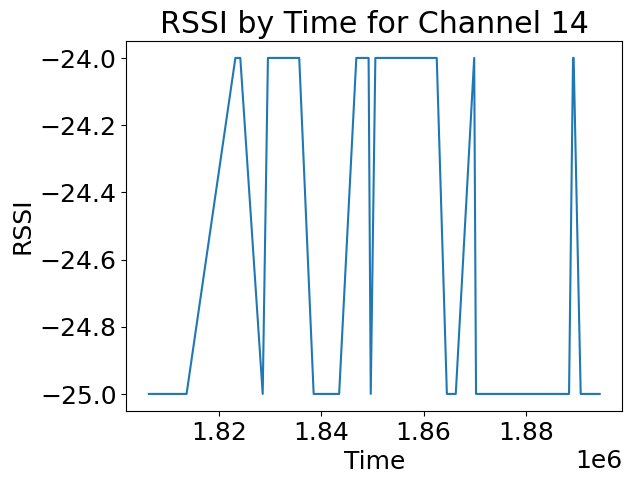

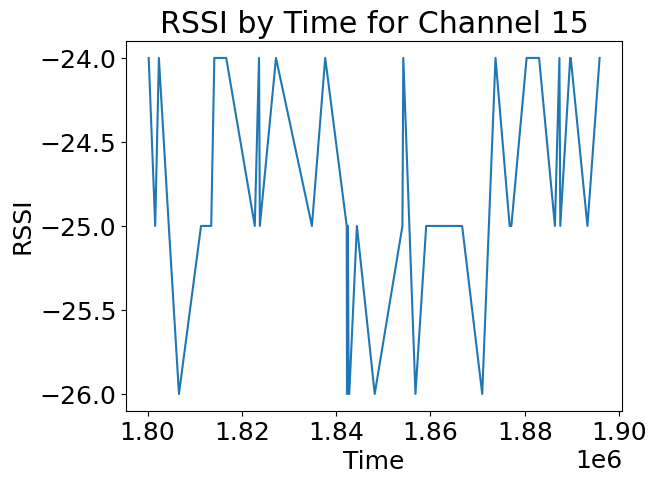

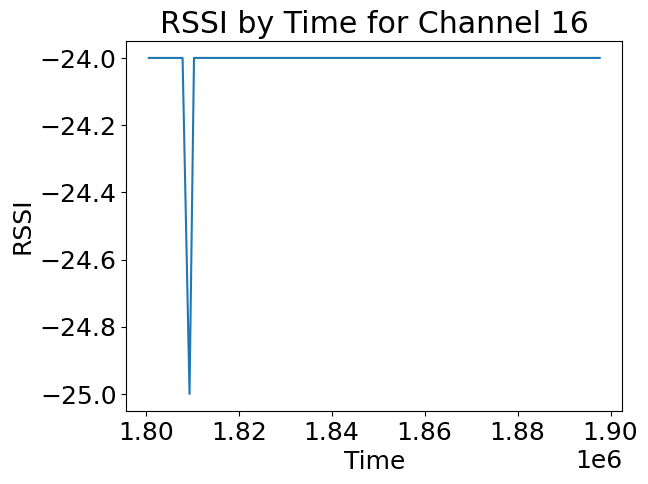

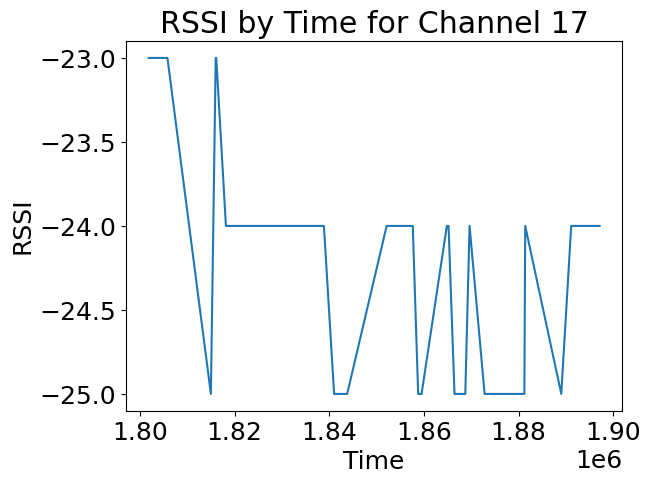

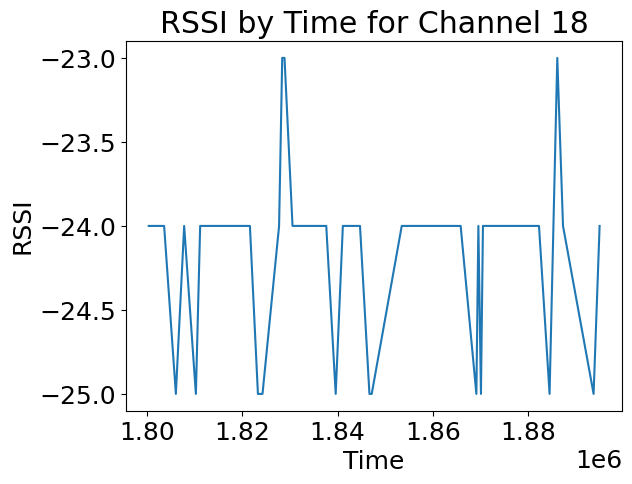

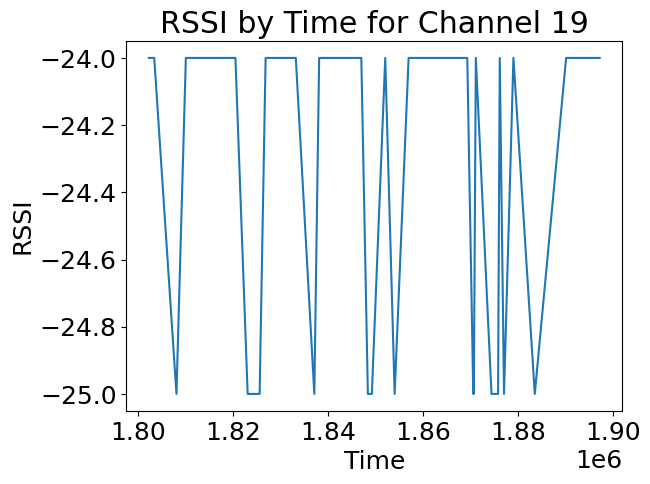

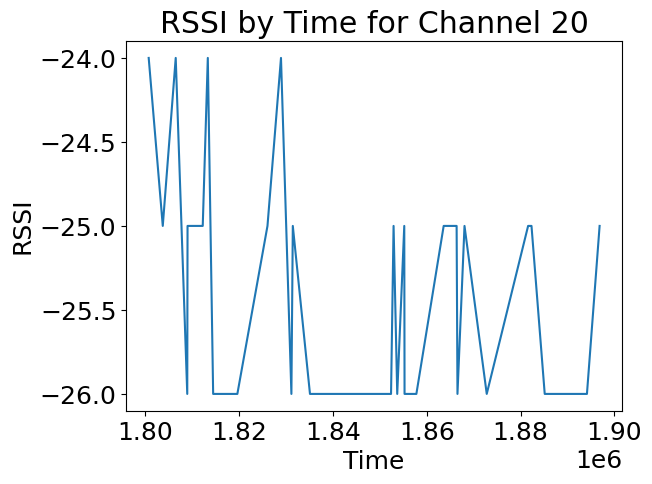

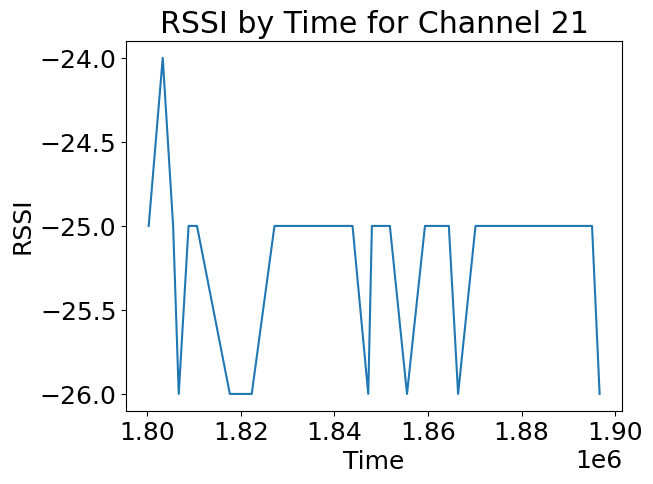

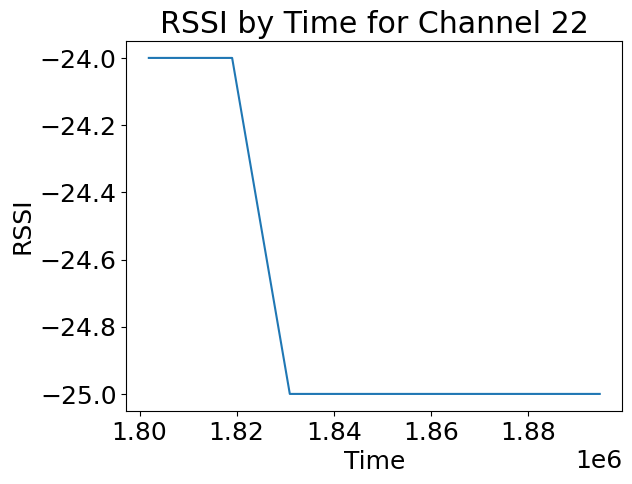

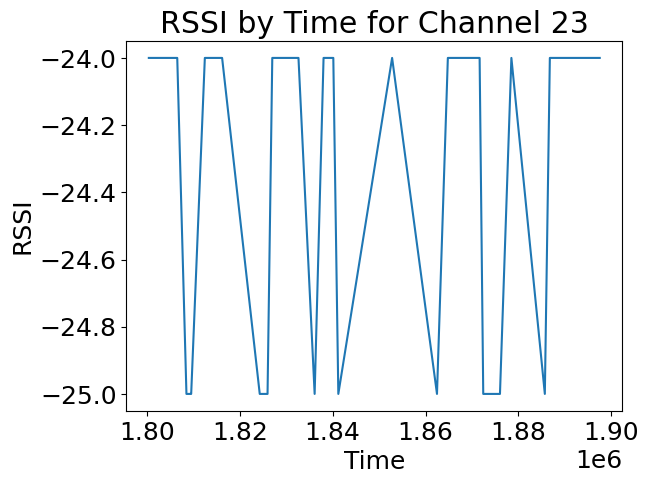

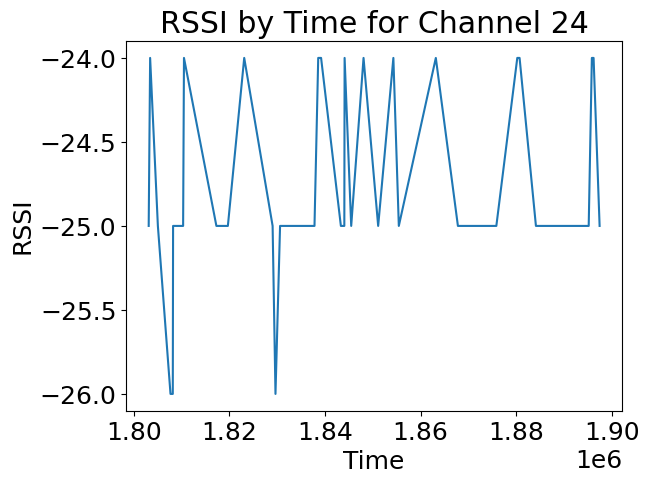

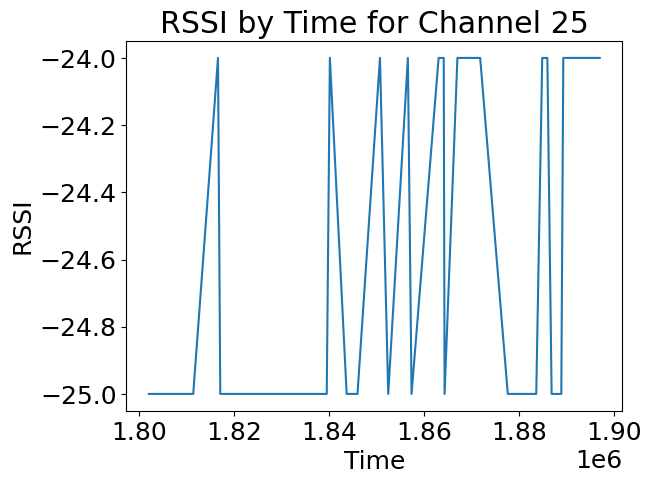

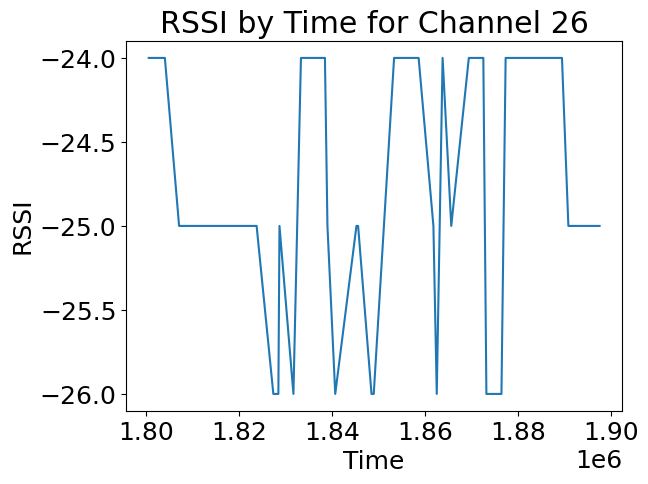

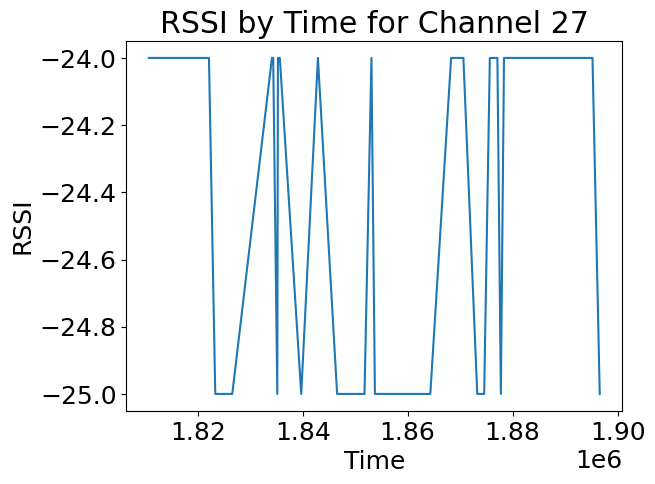

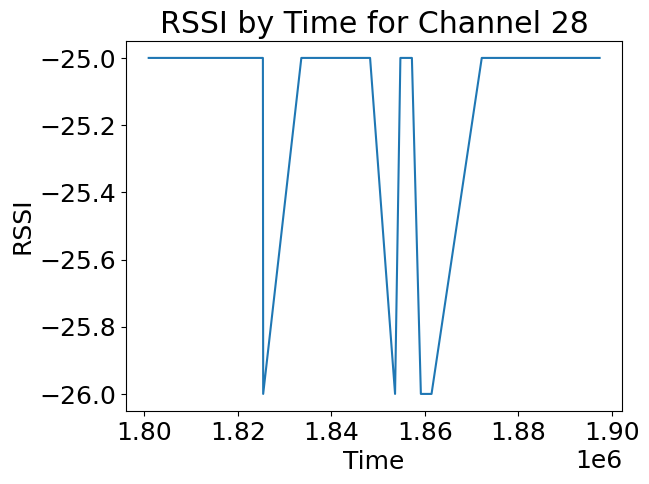

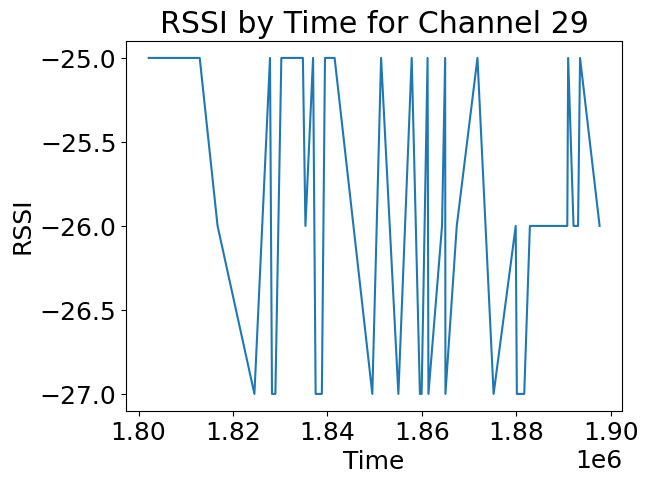

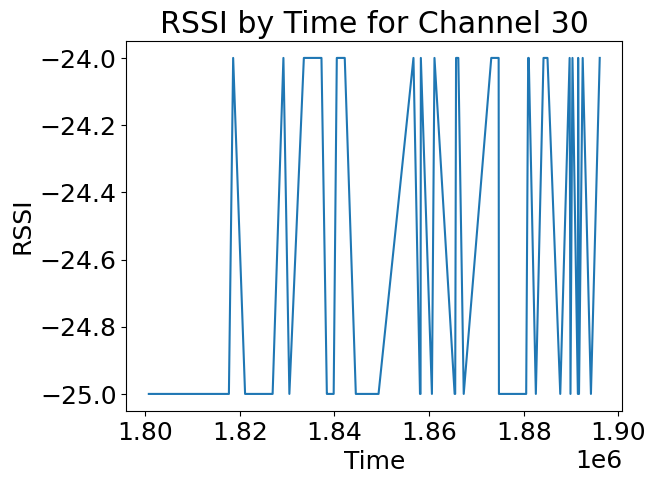

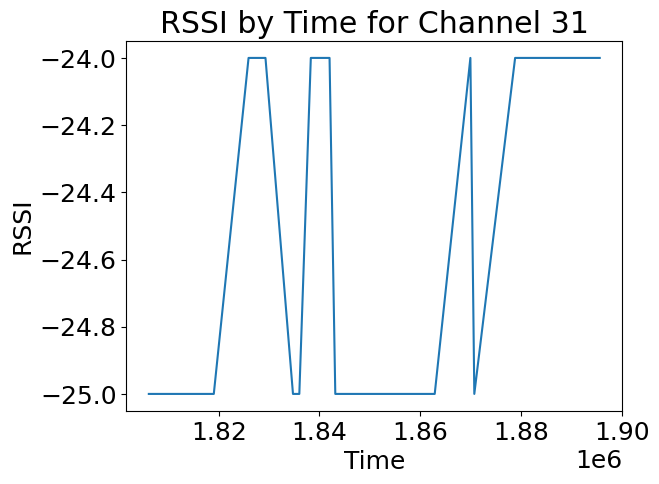

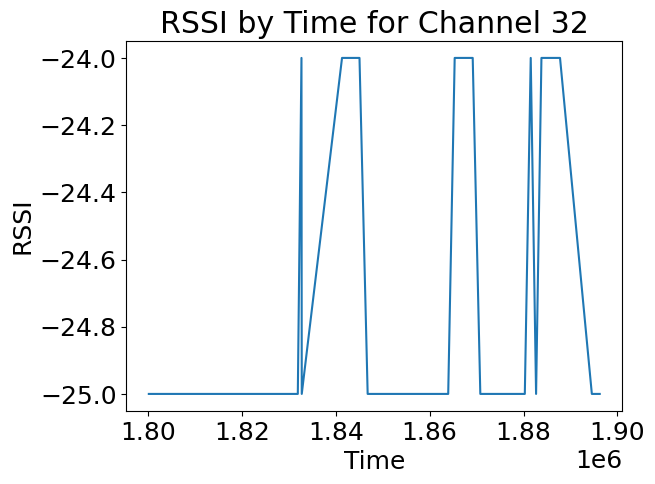

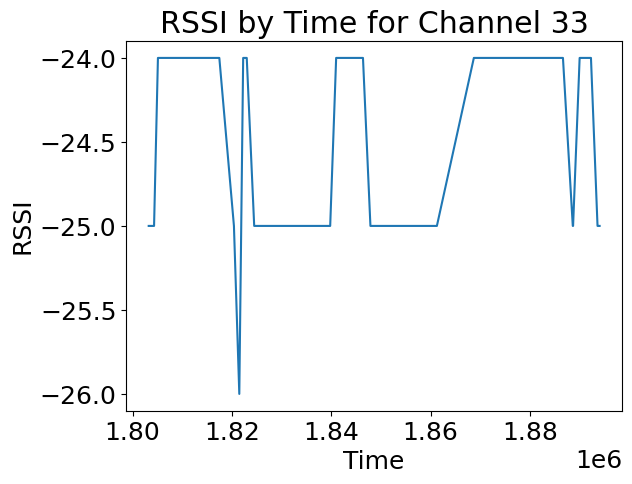

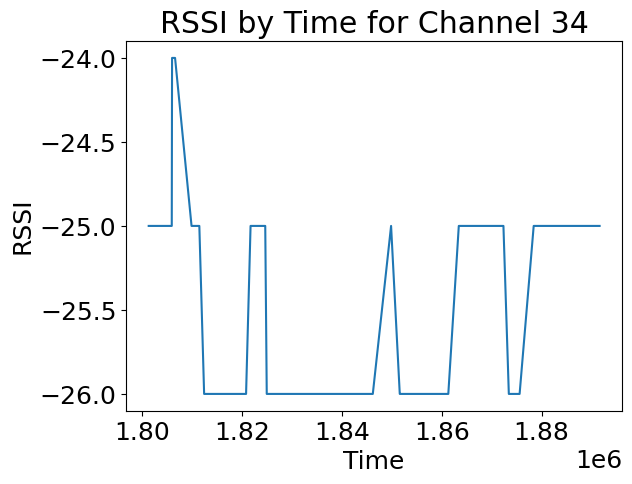

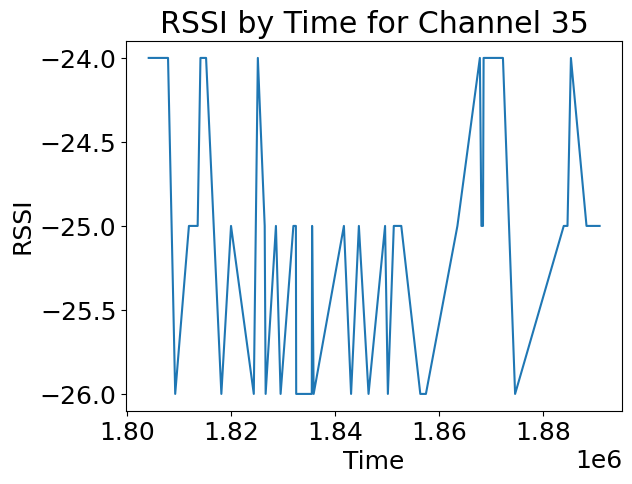

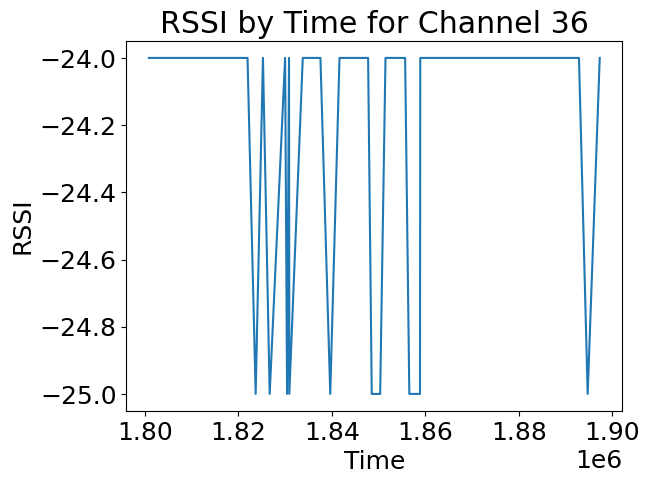

In [27]:
# Group data by channel number
grouped_data = dfs['g1']['qos'].groupby('channel_index')

# Plot RSSI by time for each channel
for channel, group in grouped_data:
    plt.plot(group['time'], group['rssi'])
    plt.title('RSSI by Time for Channel {}'.format(channel))
    plt.xlabel('Time')
    plt.ylabel('RSSI')
    plt.show()

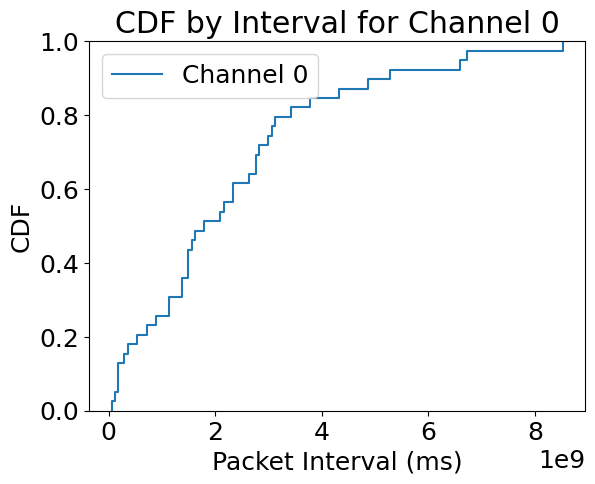

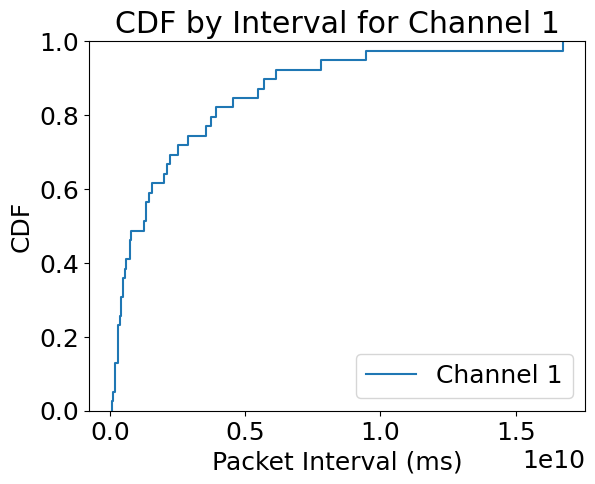

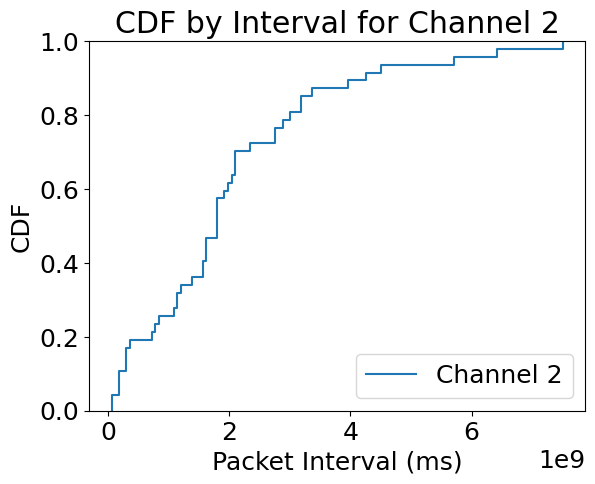

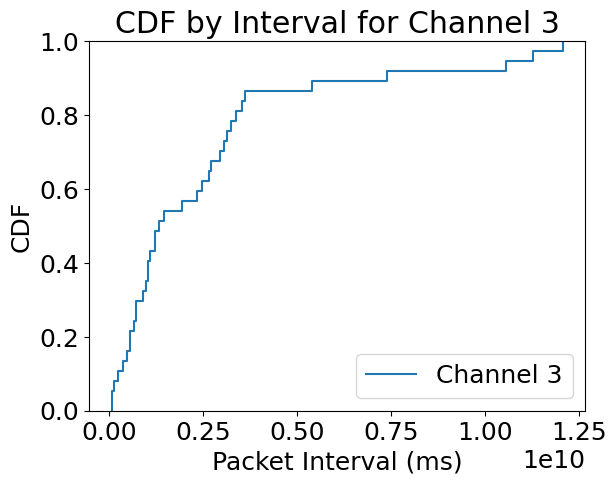

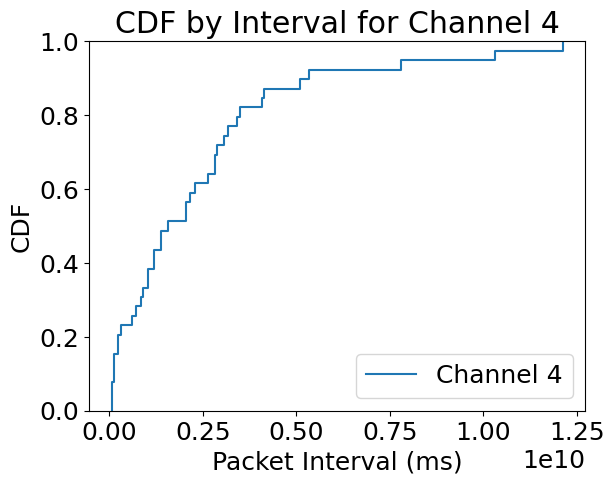

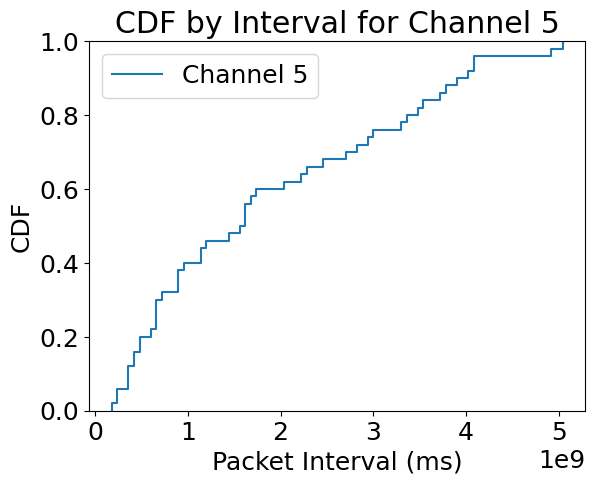

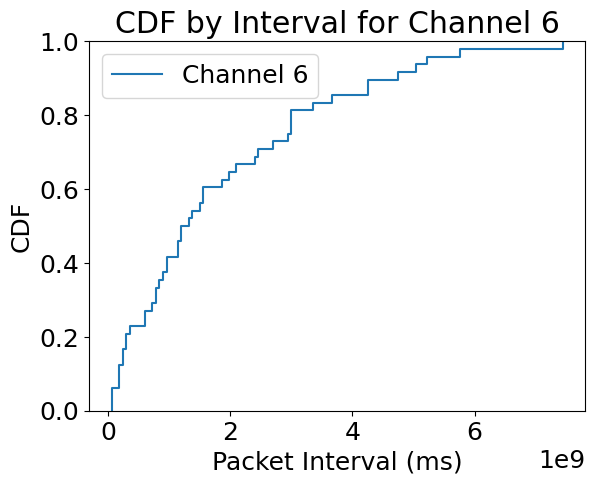

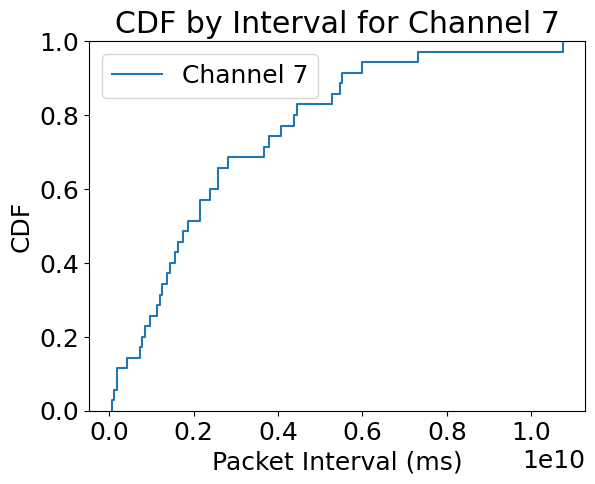

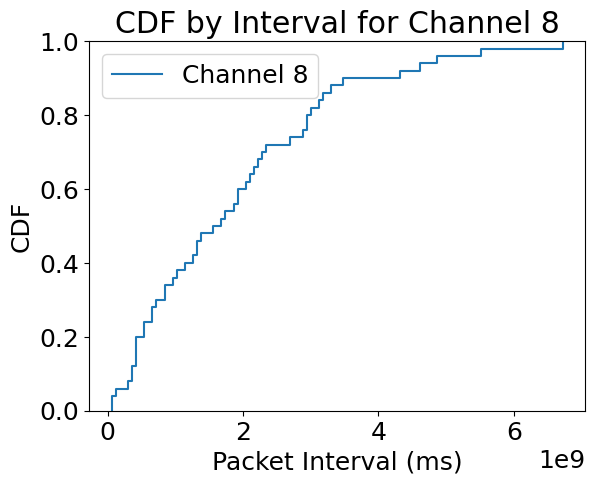

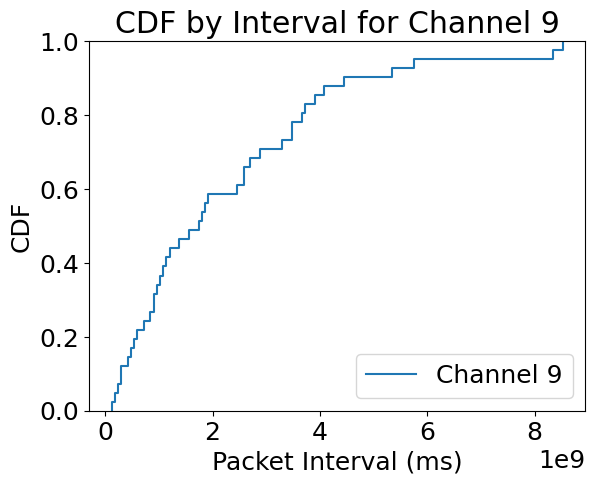

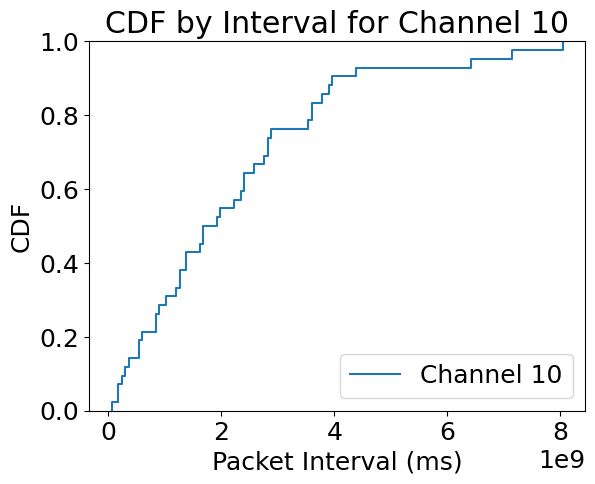

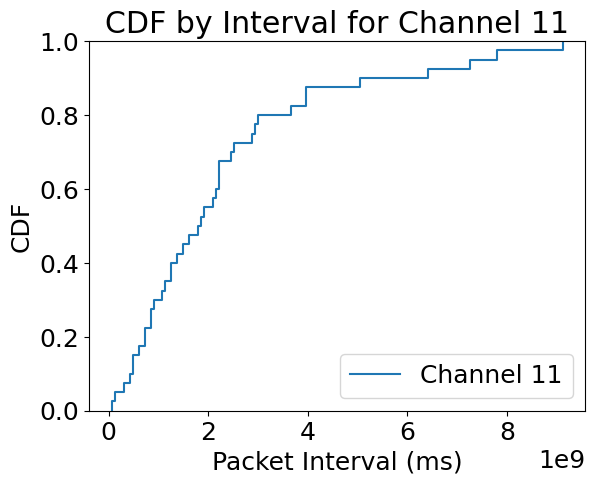

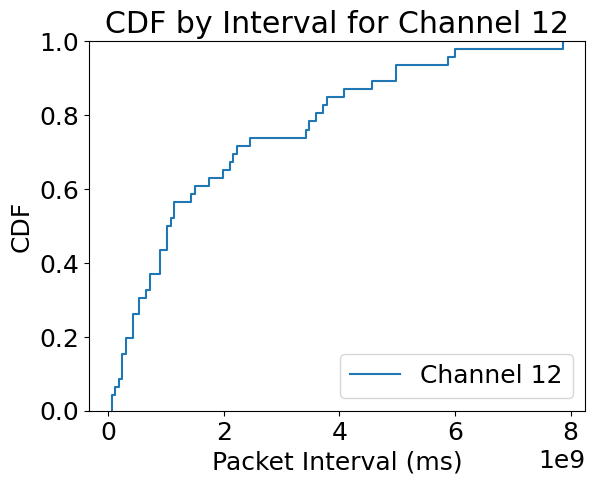

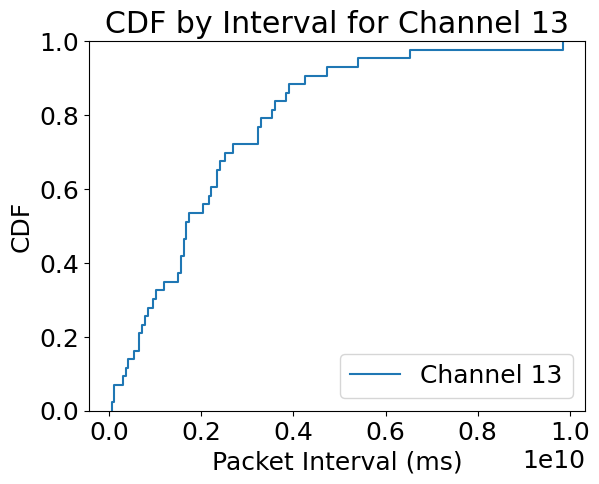

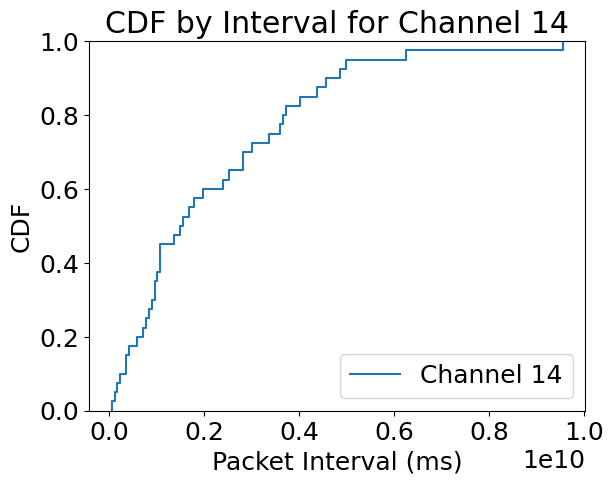

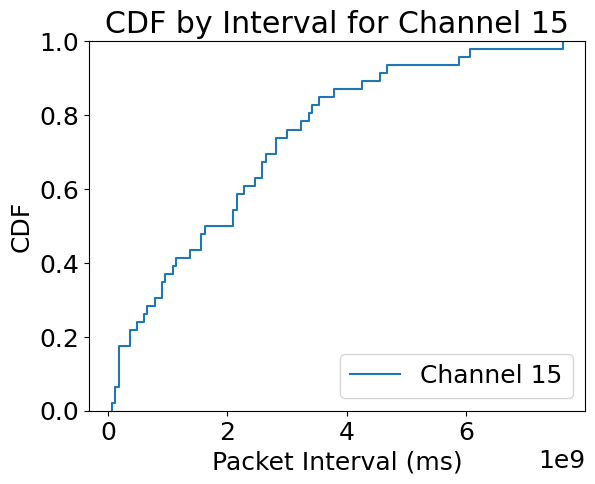

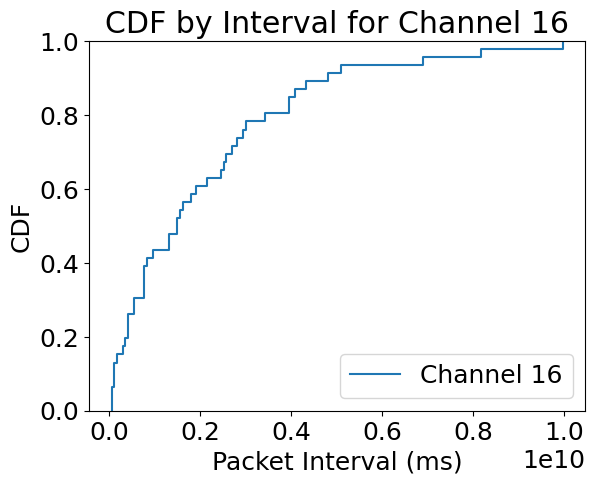

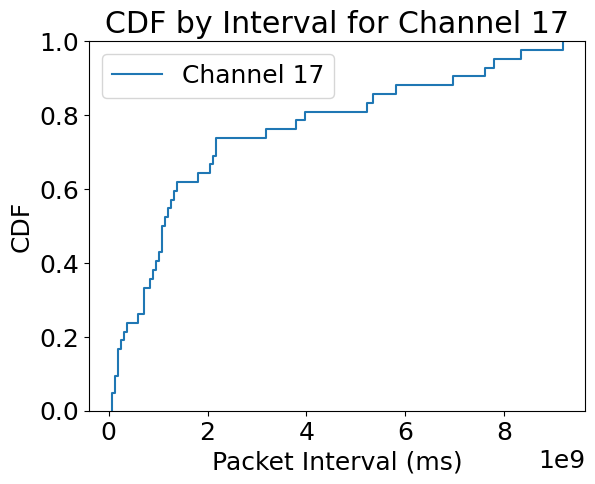

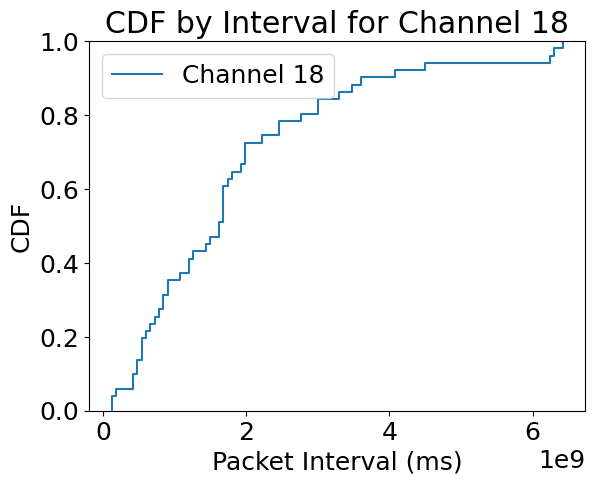

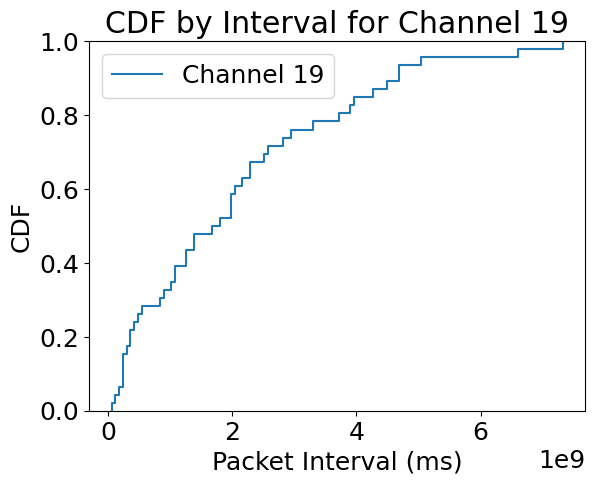

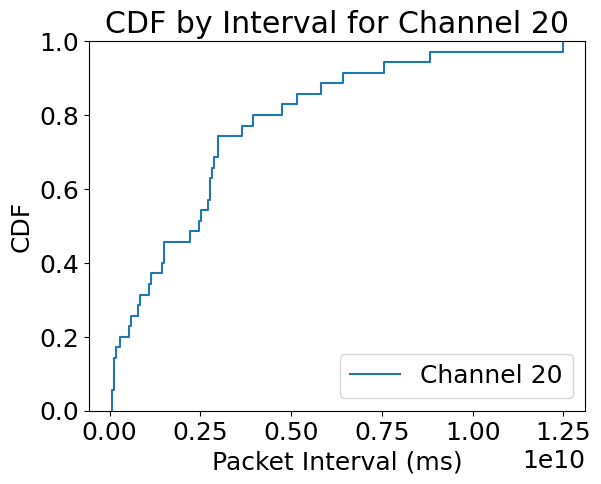

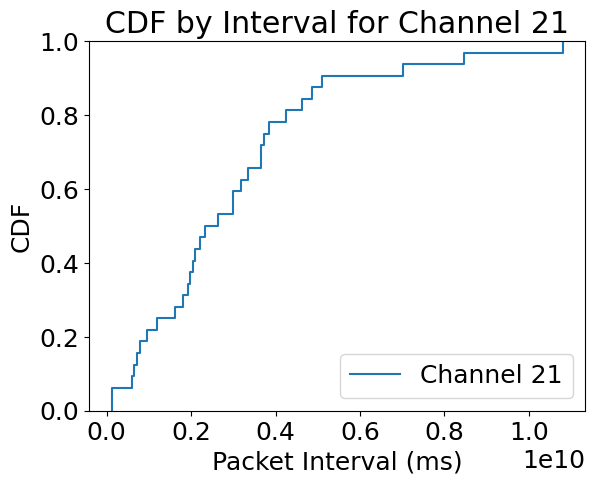

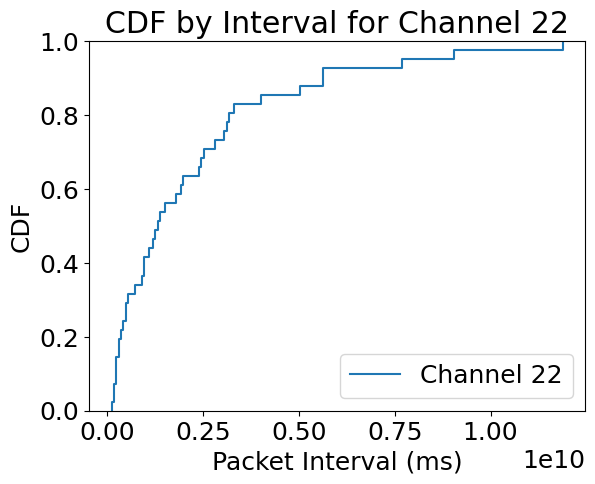

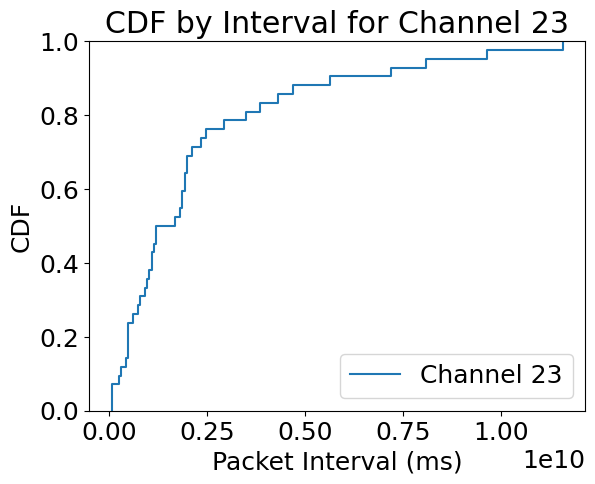

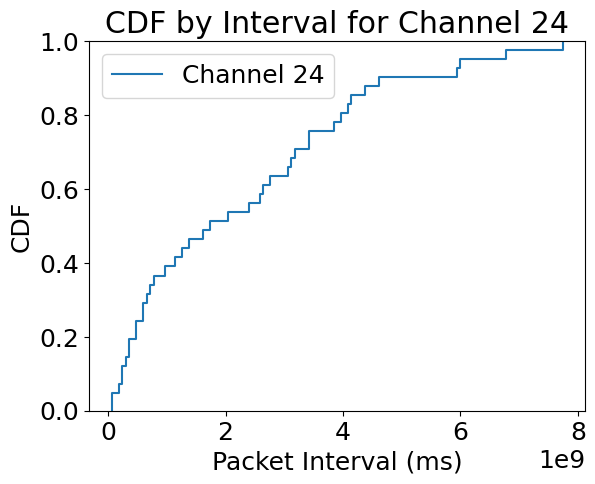

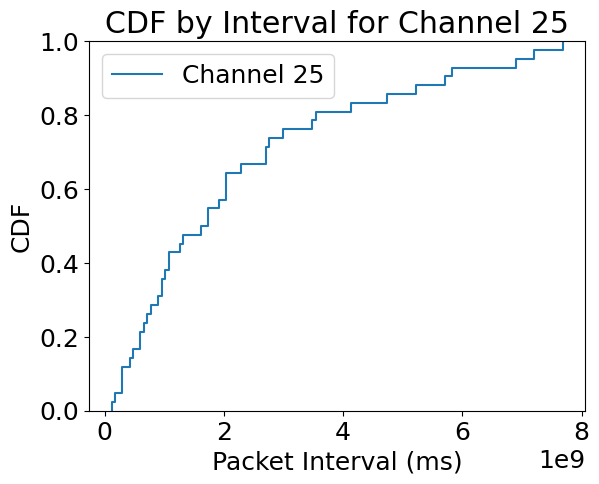

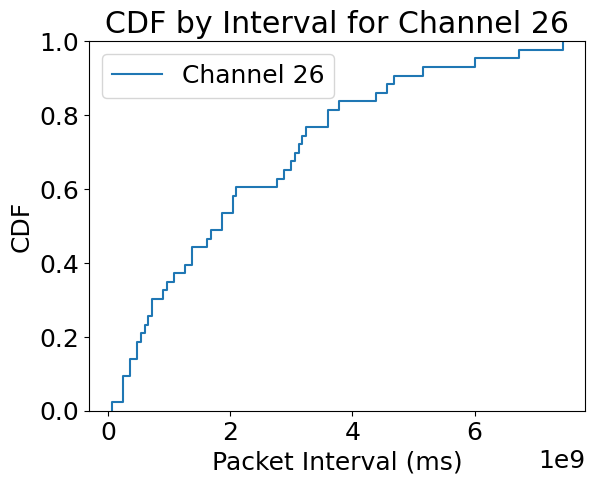

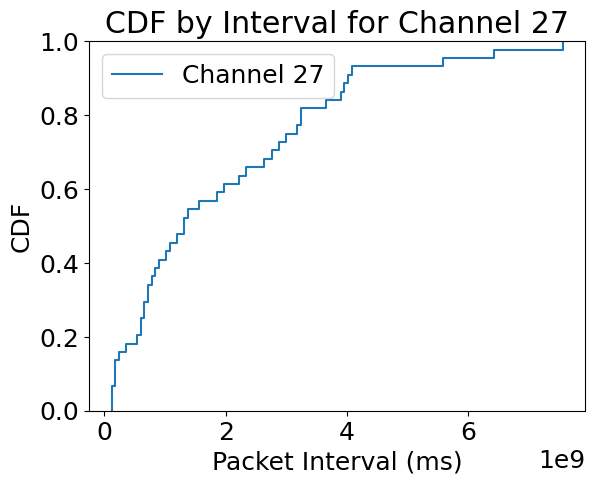

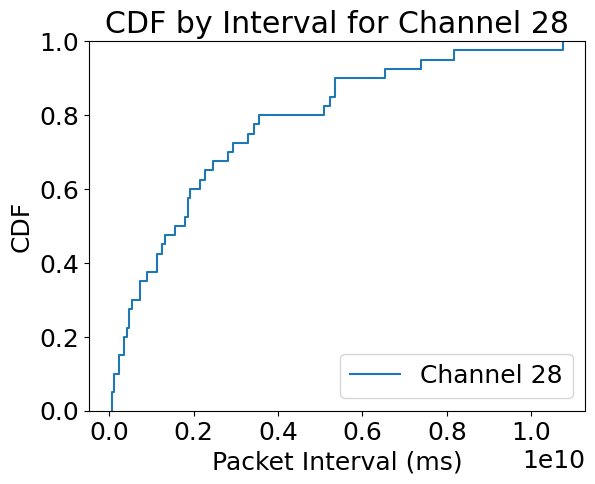

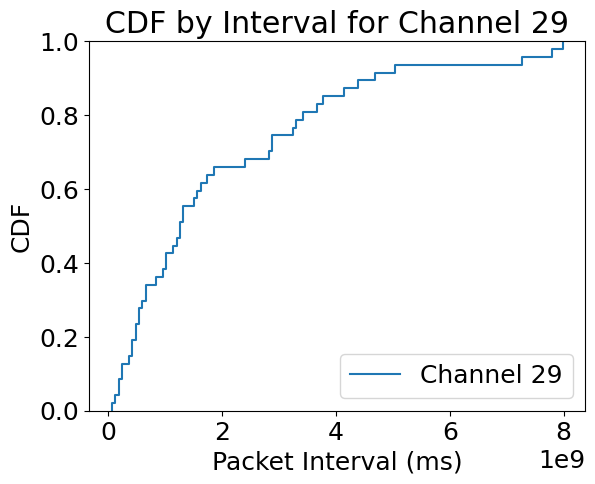

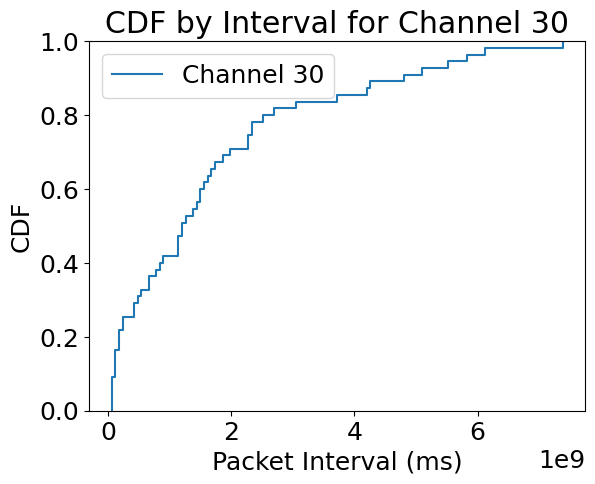

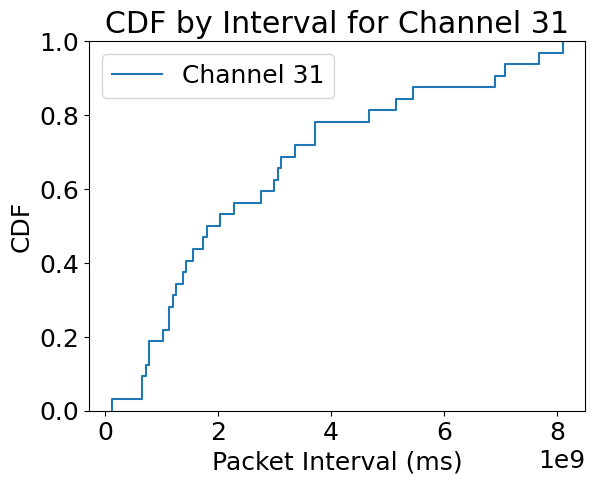

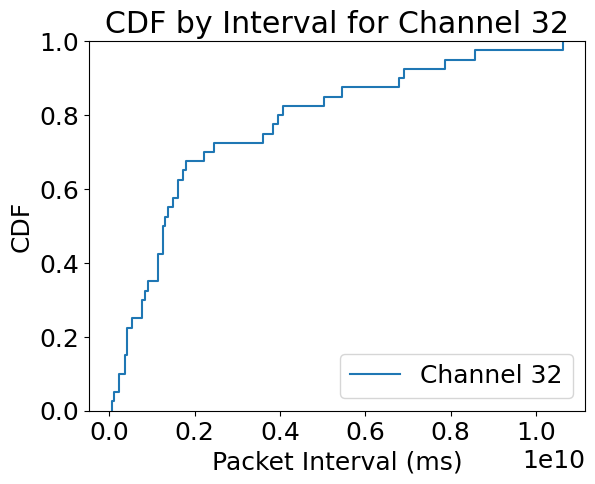

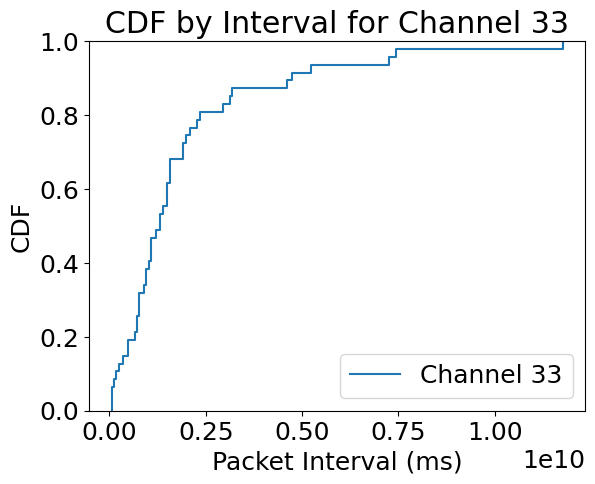

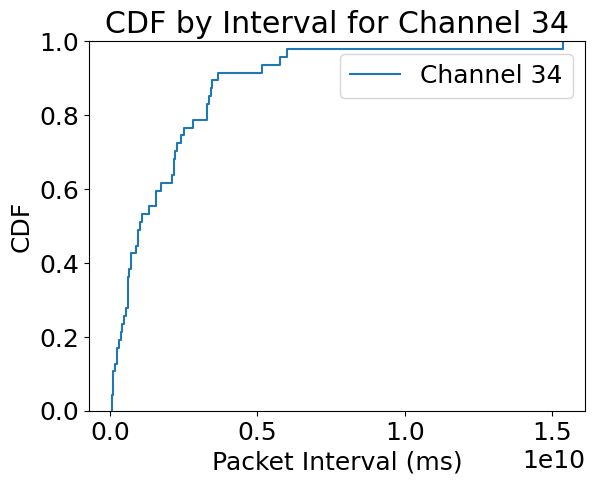

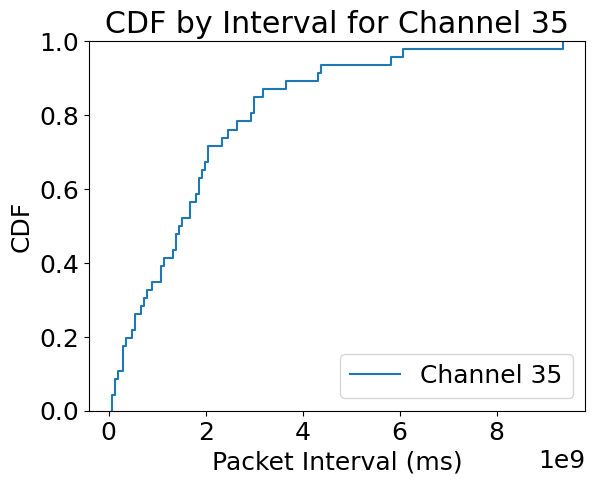

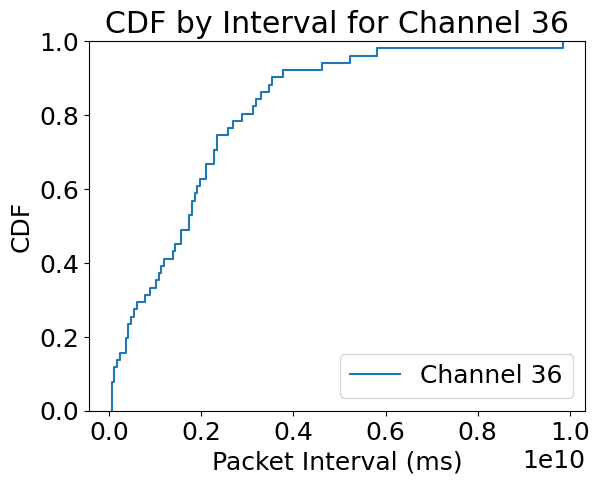

In [34]:
# Group data by channel number
grouped_data = dfs['g1']['qos'].groupby('channel_index')

# Plot ECDF for each channel
for channel, group in grouped_data:
    # Calculate the time intervals between packets
    intervals = group['timedelta'].diff().dropna()

    # Plot the ECDF using seaborn.ecdfplot
    sns.ecdfplot(intervals, label=f'Channel {channel}')

    # Set axis labels and legend
    plt.xlabel('Packet Interval (ms)')
    plt.ylabel('CDF')
    plt.legend()
    plt.title('CDF by Interval for Channel {}'.format(channel))

    # Show plot
    plt.show()

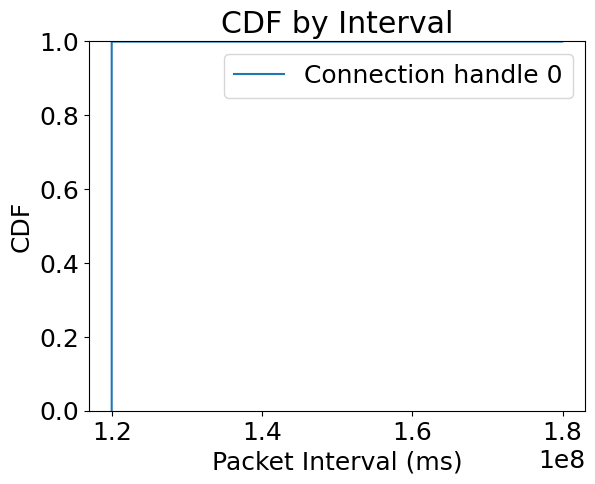

In [29]:
# Group data by connection handle
grouped_data = dfs['g1']['vs'].groupby('conn_handle')

# Plot ECDF for each connection handle
for connectionhandle, group in grouped_data:
    # Calculate the time intervals between packets
    intervals = group['timedelta'].diff().dropna()

    # Plot the ECDF using seaborn.ecdfplot
    sns.ecdfplot(intervals, label=f'Connection handle {connectionhandle}')

    # Set axis labels and legend
    plt.xlabel('Packet Interval (ms)')
    plt.ylabel('CDF')
    plt.legend()
    plt.title('CDF by Interval')

    # Show plot
    plt.show()

In [30]:
dfs['g1']['vs']

,time,conn_handle,cc,timedelta,delayed
0,1800118,0,20,0 days 00:30:00.118000,0.0
1,1800238,0,21,0 days 00:30:00.238000,0.0
2,1800358,0,22,0 days 00:30:00.358000,0.0
3,1800478,0,23,0 days 00:30:00.478000,0.0
4,1800598,0,24,0 days 00:30:00.598000,0.0
...,...,...,...,...,...
808,1897138,0,60,0 days 00:31:37.138000,0.0
809,1897258,0,61,0 days 00:31:37.258000,0.0
810,1897378,0,62,0 days 00:31:37.378000,0.0
811,1897498,0,63,0 days 00:31:37.498000,0.0


## Delay prob

In [31]:
def over360(p):
    n=6
    P = np.array(
        [([0, 1.] + [0 for i in range(n-2)])]+[[1-p,0]+[p if i==j else 0 for j in range(n-2)] for i in range(n-2)]+[([0 for i in range(n-1)] + [1])],
        dtype='float64'
    ).T
    v_init = np.array(
        [1] + [0 for i in range(n-1)],
        dtype='float64'
    )
    n_event = int(datetime.timedelta(days=365*10).total_seconds() / 0.06)
    return ((np.linalg.matrix_power(P, n_event))@v_init)[-1]

In [32]:
(dfs['g1']['qos']['crc_error_count'] + dfs['g1']['qos']['crc_ok_count']).idxmax()

0

In [33]:
pd.set_option('display.max_columns', 100)
_df = dfs['g4']['qos']
_df.loc[_df['crc_error_count']+_df['crc_ok_count']>=2].T

KeyError: 'g4'

In [ ]:
worst_p = -1
worst_group = ''
worst_addr = ''
for group, df_group in dfs.items():
    for conn_handle, addr in sorted(group_handle2addr[group].items(), key=lambda x: x[1]):
        df_qos = df_group['qos'].query('conn_handle==@conn_handle')
        # s = df_group((df_group['qos']['conn_handle']==conn_handle)&(df_group['qos']['result']!='ok'))
        s = (df_qos['result']!='ok')
        p = s.sum() / s.count()
        worst_p = max(p, worst_p)
        if p==worst_p:
            worst_group = group
            worst_addr = addr
        print(f'group:{group}, conn handle:{conn_handle}, addr: {addr}, p: {p:.3e}, p(over360):{over360(p):.3e}')

print(worst_group, worst_addr)
print(f'worst p:{worst_p:.3e}, over360: {over360(worst_p):.3e}')

group:g1, conn handle:4, addr: C2:F9:E6:45:3F:81, p: 1.279e-02, p(over360):1.000e+00
group:g1, conn handle:3, addr: C9:0C:0C:7F:29:1C, p: 3.673e-03, p(over360):3.798e-01
group:g1, conn handle:5, addr: CB:F7:79:08:DE:5E, p: 6.297e-03, p(over360):9.837e-01
group:g1, conn handle:8, addr: CF:4E:70:1E:6F:B7, p: 9.497e-03, p(over360):1.000e+00
group:g1, conn handle:0, addr: D4:8F:05:A1:2A:82, p: 4.321e-03, p(over360):5.993e-01
group:g1, conn handle:7, addr: DC:74:D7:5F:3C:65, p: 3.665e-03, p(over360):3.771e-01
group:g1, conn handle:1, addr: DD:EA:33:21:73:01, p: 2.032e-03, p(over360):4.373e-02
group:g1, conn handle:6, addr: E9:4F:A7:84:CA:42, p: 4.857e-03, p(over360):7.675e-01
group:g1, conn handle:10, addr: EB:B1:33:14:CE:B7, p: 5.872e-03, p(over360):9.556e-01
group:g1, conn handle:9, addr: EE:F3:7D:5B:8A:B5, p: 2.329e-03, p(over360):7.439e-02
group:g1, conn handle:2, addr: F7:D5:DD:39:68:28, p: 8.005e-03, p(over360):1.000e+00
group:g2, conn handle:4, addr: C9:E2:DF:C0:DB:3B, p: 1.109e-02, 